# SCENIC流程
******

## [目录](#目录)
[SCENIC简介](#SCENIC简介)<br>
[环境搭建](#环境搭建)<br>
[1.获取数据](https://github.com/aertslab/SCENIC/blob/master/inst/examples/mouseBrain_toy.loom)<br>
[2.初始化SCENIC参数](#2.初始化SCENIC参数)<br>
[3.基因的过滤、筛选](#3.基因的过滤、筛选)<br>
[4.计算spearman相关系数](#4.计算spearman相关系数)<br>
[5.推断TF靶点](#5.推断TF靶点)<br>
[6.获得共表达模块](#6.获得共表达模块)<br>
[7.创造regulons](#7.创造regulons)<br>
[8.regulon活性评分](#8.regulon活性评分)<br>
[9.根据阈值进行二分类](#9.根据阈值进行二分类)<br>
[10.相关分析](#10.相关分析)<br>
[11.基因调控网络可视化](#11.基因调控网络可视化)<br>
[12.完整代码](#12.完整代码)<br>
[13.输出文件](#13.输出文件)<br>
[参考文献](#参考文献)<br>
[参考网站](#参考网站)<br>

## SCENIC简介
SCENIC分为四步进行GRN分析：
+ GENIE3/GRNBoost：基于共表达情况鉴定每个TF的潜在靶点；过滤表达矩阵并运行R包GENIE3/GRNBoost；将得到的靶点格式化为共表达模块。
+ RcisTarget：基于DNA-motif 分析选择潜在的直接结合靶点（调控原件），鉴定细胞状态和细胞的调控分子。
+ AUCell：分析每个细胞的网络活动度，计算AUC对细胞的调控元件进行评分；将网络活动度转为二分类矩阵（on、off）。
+ 细胞聚类：基于GRN的活动度鉴定稳定的细胞状态并对结果进行探索。


## 环境搭建
<br><font color="red">📌注意：SCENIC最好基于R语言版本4.0以上去安装。</font> <br>
SCENIC的环境需要依赖自身所带的包和motif数据库，按如下代码可以进行安装。

In [ ]:
if (!requireNamespace("BiocManager", quietly = TRUE)) install.packages("BiocManager")
BiocManager::install(c("GENIE3", "AUCell", "RcisTarget"), version = "3.8")
# Also required:
install.packages('zoo')
# Recommended to run AUCell:
BiocManager::install(c("mixtools", "rbokeh"))
# To visualize the binary matrices and perform t-SNEs:
BiocManager::install(c("NMF", "pheatmap", "Rtsne", "R2HTML"))
# To support paralell execution (not available in Windows):
BiocManager::install(c("doMC", "doRNG"))
# To export/visualize in http://scope.aertslab.orgif (!requireNamespace("devtools", quietly = TRUE)) install.packages("devtools")
devtools::install_github("aertslab/SCopeLoomR", build_vignettes = TRUE)
# Other dependencies for the examples (lower priority)
BiocManager::install(c("SingleCellExperiment"))
# install.packages("devtools")
devtools::install_github("aertslab/SCENIC")
packageVersion("SCENIC")

下载motif分析，这一步时间会比较久。

In [ ]:
dbFiles <- c("https://resources.aertslab.org/cistarget/databases/homo_sapiens/hg19/refseq_r45/mc9nr/gene_based/hg19-500bp-upstream-7species.mc9nr.feather","https://resources.aertslab.org/cistarget/databases/homo_sapiens/hg19/refseq_r45/mc9nr/gene_based/hg19-tss-centered-10kb-7species.mc9nr.feather")
dbFiles <- c("https://resources.aertslab.org/cistarget/databases/mus_musculus/mm9/refseq_r45/mc9nr/gene_based/mm9-500bp-upstream-7species.mc9nr.feather","https://resources.aertslab.org/cistarget/databases/mus_musculus/mm9/refseq_r45/mc9nr/gene_based/mm9-tss-centered-10kb-7species.mc9nr.feather")
dbFiles <- c("https://resources.aertslab.org/cistarget/databases/drosophila_melanogaster/dm6/flybase_r6.02/mc8nr/gene_based/dm6-5kb-upstream-full-tx-11species.mc8nr.feather")
# dir.create("cisTarget_databases"); setwd("cisTarget_databases") # if needed

for(featherURL in dbFiles)
{
download.file(featherURL, destfile=basename(featherURL)) 
descrURL <- gsub(".feather$", ".descr", featherURL)
if(file.exists(descrURL))  download.file(descrURL, destfile=basename(descrURL))
}

>📰扩展阅读：<br>
> 1) [motif分析-RcisTarget包的使用](https://mp.weixin.qq.com/s/mBR3IwWvQDcTOXNwM_YCEg) <br>

<h2 id="1">1.获取数据</h2>

本示例数据是官网提供的一个loom文件，通常分析的时候也可以不使用loom文件，用一个基因表达矩阵（行是基因，列是细胞）和一个细胞信息的矩阵（非必要）来代替。这里用的基因表达矩阵是小鼠大脑的200个细胞和862个基因，细胞信息有celltype、nGene、nUMI。
可以通过下面的链接下载本例使用的loom文件：[数据下载](https://github.com/aertslab/SCENIC/blob/master/inst/examples/mouseBrain_toy.loom)

In [ ]:
#加载包
library(SingleCellExperiment)
library(SCENIC)
library(AUCell)
library(RcisTarget)
library(SingleCellExperiment)
library(GENIE3)
library(doRNG)
library(arrow)
library(SCopeLoomR)
library(foreach)

In [ ]:
#加载loom文件，文件内包含了一个基因表达矩阵和细胞的信息
loom <- open_loom("mouseBrain_toy.loom")
exprMat <- get_dgem(loom)
#提供cell info或者表型相关的信息,用于后面的比较分析，但没有这个信息也可以
cellInfo <- get_cell_annotation(loom)
close_loom(loom)

>📰扩展阅读：<br>
> 1) [R包SCENIC:input数据准备](https://www.jianshu.com/p/cc3e13ef9c0b) <br>

<h2 id="2">2.初始化SCENIC参数</h2>

In [ ]:
#初始化设置
#cisTarget_databases：每个集合中的motifs 或 ChIP-seq 轨道的转录因子的注释，这里选择的是小鼠的数据
scenicOptions <- initializeScenic(org="mgi", dbDir="cisTarget_databases", nCores=10)
# [email protected]$cellInfo <- "int/cellInfo.Rds"
saveRDS(scenicOptions, file="int/scenicOptions.Rds")

<h2 id="3">3.基因的过滤、筛选</h2>

最好使用较松的过滤标准，移除低表达或者少数细胞表达的基因
+ minCountsPerGene：平均每个基因的读序数<br>
目的：是移除疑似“噪声”的基因，默认保存所有样本≥6UMI counts的基因，根据数据集的表达量单位（UMI,TPM等)校正。

+ minSamples：表达该基因的细胞数<br>
目的：移除少量“噪声”细胞，即该基因在少数细胞高表达，导致噪声产生，默认保存至少在1%的细胞表达的基因。为避免移除有生物学意义的罕见细胞，推荐设置低于细胞最小分群占比的百分数作为筛选标准。

+ 仅保留RcisTarget包中数据库有的基因<br>
目的：移除下游分析不需要的基因，节省GENIE3/GRNBoost运行的时间。

In [ ]:
genesKept<-geneFiltering(exprMat, scenicOptions=scenicOptions,
                 minCountsPerGene=3*.01*ncol(exprMat),
                minSamples=ncol(exprMat)*.01)
#从exprMat取过滤后的基因的部分矩阵作为过滤后的矩阵exprMat_filtered
exprMat_filtered <- exprMat[genesKept, ]

<h2 id="4">4.计算spearman相关系数</h2>
共表达分析的结果中既有正向调控也有负向调控，GENIE3无法区分。因此需要相关性矩阵帮助筛选共表达模块中和TF正相关的基因。

In [ ]:
runCorrelation(exprMat_filtered, scenicOptions)

<h2 id="5">5.推断TF靶点</h2>

函数 runGenie3 以默认参数运行r包GENIE3，将RcisTarget的数据库作为候选的调控因子。GENIE3运用了随机森林的算法，每次运行的结果都有些许不同，ntrees越多，可变性就越低。设置set.seed可以产生较为准确的结果。这一步耗时较长，这次运行的100kb左右的数据要跑几分钟，数据量大的话需要跑几天的时间。
主要是**为了在参考数据库找出输入基因中哪些是TF，计算每个TF和各个基因之间的相关性权重。**权重其实也就是TF对gene表达量的贡献。

In [ ]:
# log转换
exprMat_filtered <- log2(exprMat_filtered+1) 
# 运行GENIE3
runGenie3(exprMat_filtered, scenicOptions)

>📰扩展阅读：<br>
> 1) [单细胞SCENIC分析原理和流程介绍](https://www.jianshu.com/p/093a835ab056) <br>

<h2 id="6">6.获得共表达模块</h2>
得到上面的TF和gene的权重矩阵以后，就可以生成以TF为核心的geneset。（比如TF1它可能对gene1、gene5、gene12...的预测都比较好，就可以得到以TF1为核心的geneset）。

In [ ]:
#log转换
exprMat_log <- log2(exprMat+1)
#获得共表达模块
scenicOptions <- runSCENIC_1_coexNetwork2modules(scenicOptions)

>📰扩展阅读：<br>
> 1) [RNA-seq数据的基因共表达网络分析](https://www.jianshu.com/p/b05145d0020a) <br>

<h2 id="7">7.创造regulons</h2>

通过RcisTarget数据库对得到的共表达模块进行修剪。通俗的讲就是**在计算出的TF-gene对中，结合数据库查看该gene上游序列是否存在该TF结合的motif。**从而剔除TF非直接调控基因的共表达模块，保留Motif分析共表达模块内与TF有直接调控关系的基因，得到Regulon。（RcisTarget数据库中的数据目前只支持人，鼠，果蝇三个物种。）  
SCENIC使用以下6种方法**过滤掉低相关性的TF-genes共表达基因集，得到以TF为核心的regulon。**这一步运行得到的结果中包含了一列corr，是runCorrelation()得到的结果。1代表激活，-1代表抑制，0代表中性，SCENIC只会采用corr值为1的数据用于后续分析，以得到正调控共表达模块。

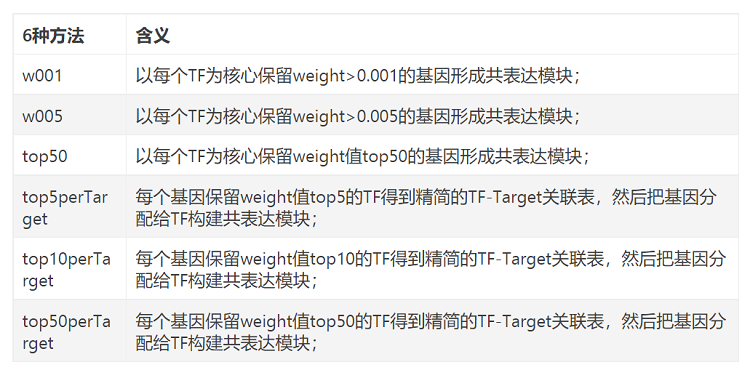

In [ ]:
#创建regulons
scenicOptions <-runSCENIC_2_createRegulons(scenicOptions, coexMethod=c("top5perTarget"))

 >📰扩展阅读：<br>
> 1) [Regulon调控子分析](https://www.sohu.com/a/391493120_464200) <br>

<h2 id="8">8.regulon活性评分</h2>

每个Regulon就是一个转录因子及其直接调控靶基因的基因集，**SCENIC接下来的工作就是对每个regulon在各个细胞中的活性评分，得到每个基因集在每个细胞的AUC score矩阵（AUC代表来与细胞内其他基因相比，特征基因中代表基因的比例及其相对表达值）。**评分是基于recovery analysis，根据基因的表达值进行，分数越高代表基因集的激活程度越高。

In [ ]:
scenicOptions <- runSCENIC_3_scoreCells(scenicOptions, exprMat_log)

通过这一步的评分，SCENIC可以自动生成一个有所有regulon在细胞的AUCscore热图Step3_RegulonActivity_heatmap.pdf，这里的y轴代表了不同的regulon，x轴代表不同的细胞。颜色代表的就是所有regulon的AUC分数，颜色越偏向蓝色代表该regulon在此细胞里的活性越低，颜色越偏向红色代表该regulon在此细胞里的活性越高，如下图所示。

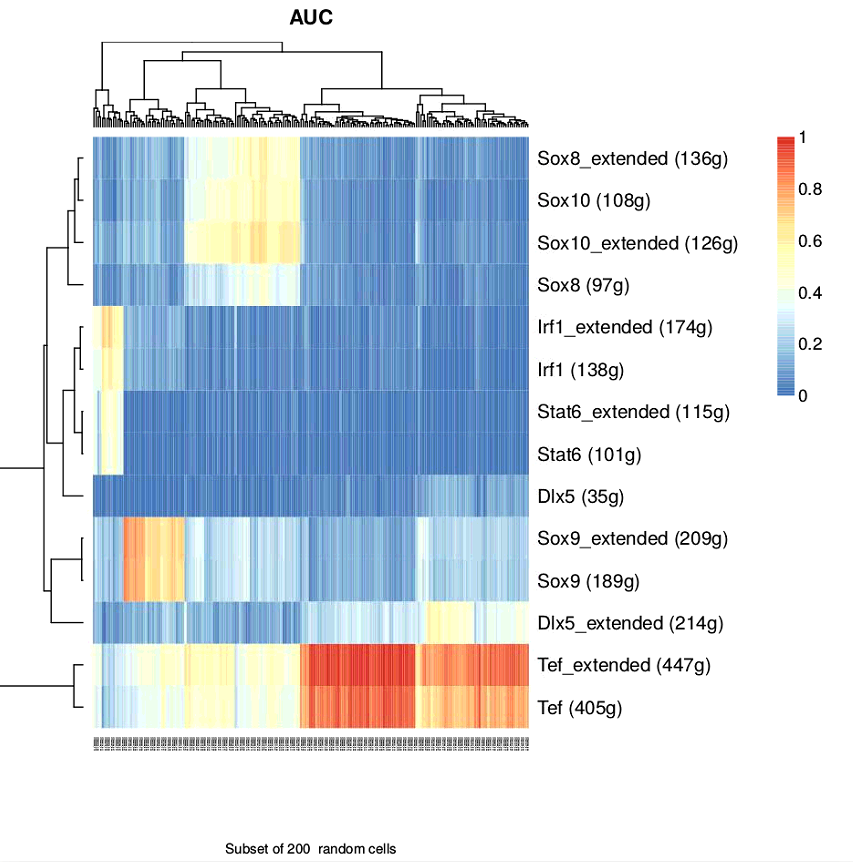

这一步还会产生每一个regulon的tSNE降维图，例如下图是基因集Dlx5在每个细胞上的分布。

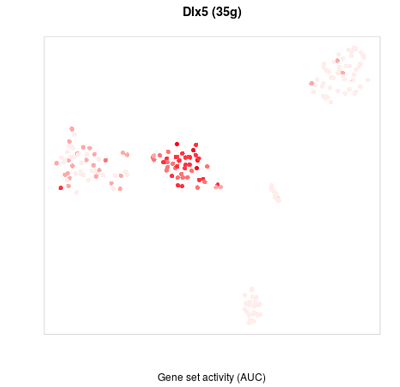

<h2 id="9">9.根据阈值进行二分类</h2>

对于细胞类型清晰的数据集而言，构建regulons并对其活性打分足够后续分析。但是，在很多情况下将评分转换为二进制的“开/关”(on|off)，则既方便解释，又能最大化体现细胞类型的差异。将特定的regulon转换为“0/1”有利于探索和解释关键转录因子。将所有的regulons转换为“0/1”后创建二进制的活性矩阵，则可以用于细胞聚类，由于regulon是基于整体评分的，**对消除技术偏倚如个别基因的dropout特别有用。**AUCell会自动计算可能的阈值进行“0/1”转换。

In [ ]:
scenicOptions <- runSCENIC_4_aucell_binarize(scenicOptions)

通过这一步的二分类，SCENIC可以自动生成一个有所有regulon在细胞的AUCscore热图Step4_BinaryRegulonActivity_heatmap_all.pdf，这里的y轴代表了不同的regulon，x轴代表不同的细胞。由于只有0和1两种状态，所以下面的热图只有黑白两色，如下面图片所示。

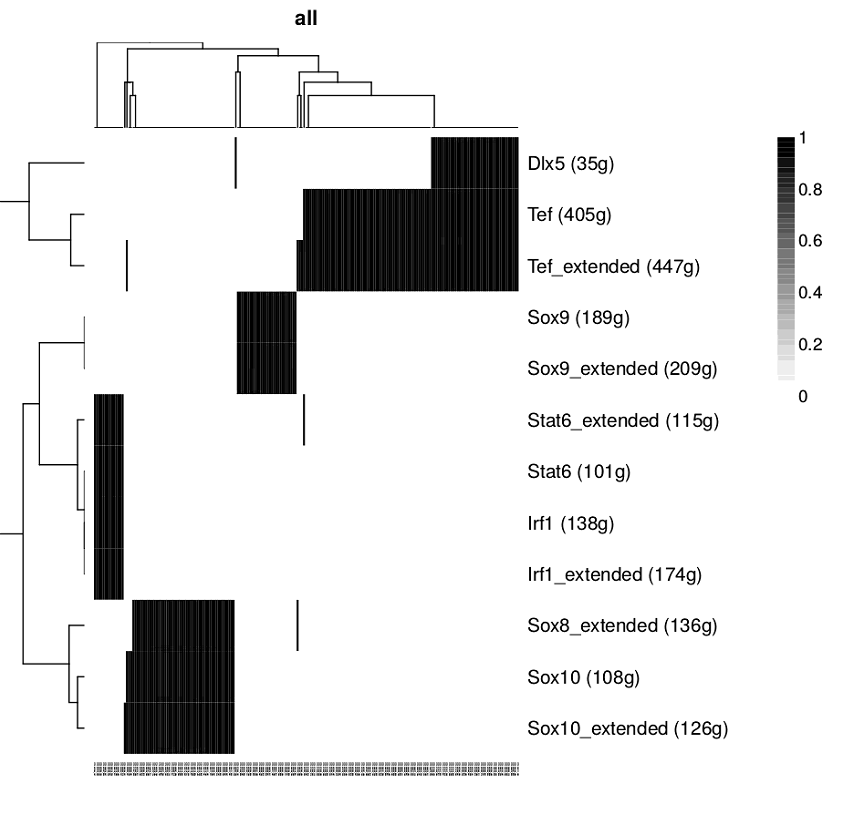

runSCENIC_4_aucell_binarize还会对最活跃的7个regulon画出一个tSNE降维图，这里每个点代表一个细胞，因为这里也是用的上面的结果，所以也是黑白两色的，黑色就代表该细胞有活跃的regulon，如下图所示。

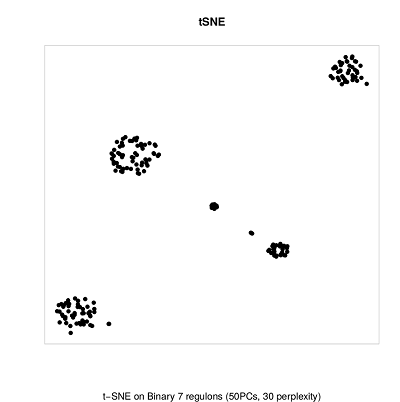

也可以直接在R里面画出相应选择的regulon的tSNE降维图。

In [ ]:
tSNE_scenic <- readRDS(tsneFileName(scenicOptions))
aucell_regulonAUC <- loadInt(scenicOptions, "aucell_regulonAUC")
# Show TF expression:
par(mfrow=c(2,3))
AUCell::AUCell_plotTSNE(tSNE_scenic$Y, exprMat, aucell_regulonAUC[onlyNonDuplicatedExtended(rownames(aucell_regulonAUC))[c("Dlx5", "Sox10", "Sox9","Irf1", "Stat6")],], plots="Expression")

runSCENIC_4_aucell_binarize还生成了两个箱型图，第一个是指每个regulon有多少细胞，第二个是指每个细胞有多少的regulon。

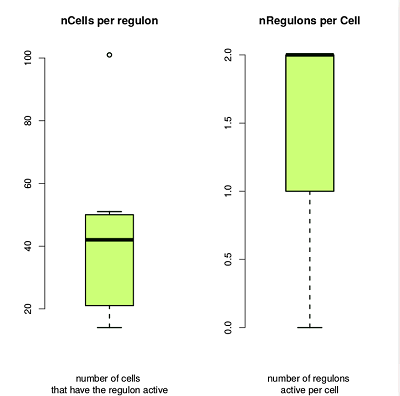

这里还会产生一个相似的regulon的tSNE降维图，但只有AUC分数大于0.099才会标出来该细胞。这里的0.099指的是前面的AUC算出来的阈值的分数，这个分数我们也可以自己定义。通常来说，当AUC的分数大于0.099的时候，这个regulon在细胞里面的活性就已经很强了。

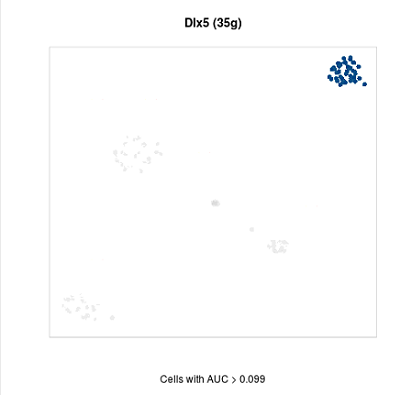

这一步也会产生一个柱状图，这里的x轴是AUC的分数值，y轴是频率。通过这个图，我们可以看出某一个regulon在所有的细胞当中的AUC分数的分布情况。regulon标记仅在一部分细胞中激活的理想情况应返回双峰分布（如下图），或带有长尾的分布。**AUCell会自动计算可能出现的阈值，比如曲线的拐点（双峰分布的时候最常使用），我们也可以根据峰值的分布情况手动地去调整阈值。当regulon当中的gene较少的时候要特别注意，最好手动调整阈值。**  
这里需要注意的是，AUC分类的时候允许将regulon高活性和低活性的分为两个不同的簇。

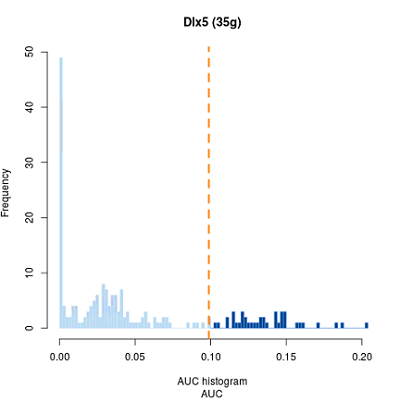

<h2 id="10">10.相关分析</h2>

使用以下代码可以直接查看regulons的情况，也可以选取需要查看的regulon的TF和该regulon调控的gene。

In [ ]:
regulons <- loadInt(scenicOptions, "regulons")
regulons[c("Dlx5", "Irf1")]
#也可以选择由AUCell过滤过后的regulons
regulons <- loadInt(scenicOptions, "aucell_regulons")
regulons[c("Dlx5", "Irf1")]

可以使用以下代码把特定的regulon抽出来进行分析，下面就是把TF为Stat6的regulon抽出来单独变为一个list。list里面有对应的TF、所调控的gene、最好的motif、NES的值（校正后的富集得分）、motifDB的信息、TF和被调控的gene的weight（被调控的可能性）。

In [ ]:
regulonTargetsInfo <- loadInt(scenicOptions, "regulonTargetsInfo")
tableSubset <- regulonTargetsInfo[TF=="Stat6" & highConfAnnot==TRUE]
viewMotifs(tableSubset, options=list(pageLength=5)) 
#可以直接查看对应的regulon的情况
viewMotifs(tableSubset) 

SCENIC还提供了查看regulons和celltype相关性的功能，如下面代码所示。

In [ ]:
topRegulators <- reshape2::melt(regulonActivity_byCellType_Binarized)
colnames(topRegulators) <- c("Regulon", "CellType", "RelativeActivity")
topRegulators <- topRegulators[which(topRegulators$RelativeActivity>minPerc),]
viewTable(topRegulators)

当细胞种类较多的时候可以通过RSS（Regulon Specificity Score）来识别regulons的特异性。用下面的代码可以画出热点图，颜色深浅代表z-sore值，点的大小代表RSS评分。这里的x轴代表不同的细胞类型，例如中间神经元、骨髓发育细胞等等；y轴代表不同的regulon。

In [ ]:
# Cell-type specific regulators (RSS): 
regulonAUC <- loadInt(scenicOptions, "aucell_regulonAUC")
rss <- calcRSS(AUC=getAUC(regulonAUC), cellAnnotation=cellInfo[colnames(regulonAUC), "CellType"], )
rssPlot <- plotRSS(rss)
plotly::ggplotly(rssPlot$plot)

<h2 id="11">11.基因调控网络可视化</h2>

画出感兴趣的基因调控网络，这里我选择了"Stat6","Dlx5","Sox10"这三个作为示例，首先先导出成excel文件，然后通过cytoscape软件来构建基因调控网络的图像。在cytoscape里面操作后就可以得到这三个TF组成的基因调控网络，如下图所示。  
cytoscape的使用可以参考以下文章：[一网打尽：cytoscape详细教程](https://zhuanlan.zhihu.com/p/220527695)

In [ ]:
#选择感兴趣的TF
tableSubset1 <- regulonTargetsInfo[TF==c("Stat6" ,"Dlx5","Sox10")& highConfAnnot==TRUE]
#导出成excel的格式
write.csv(tableSubset1,file="test_csv.csv",row.names= FALSE)

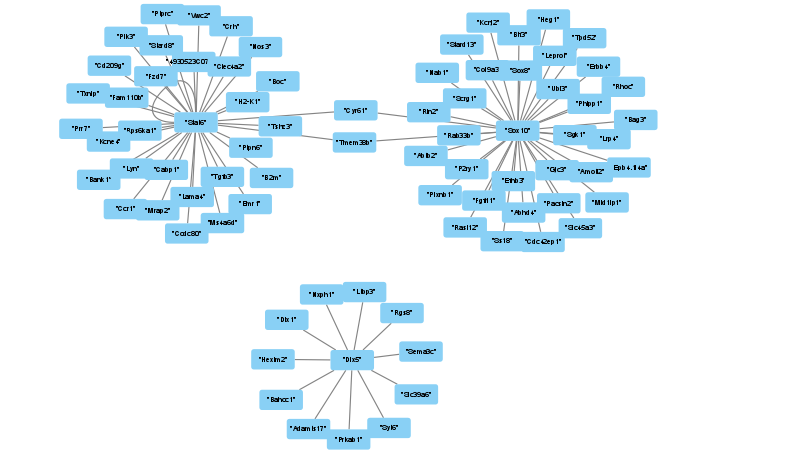

<h2 id="12">12.完整代码</h2>

In [ ]:
#加载包
library(SingleCellExperiment)
library(SCENIC)
library(AUCell)
library(RcisTarget)
library(SingleCellExperiment)
library(GENIE3)
library(doRNG)
library(arrow)
library(SCopeLoomR)
library(foreach)

#加载loom文件，文件内包含了一个基因表达矩阵和细胞的信息
loom <- open_loom("mouseBrain_toy.loom")
exprMat <- get_dgem(loom)
#提供cell info或者表型相关的信息,用于后面的比较分析，但没有这个信息也可以
cellInfo <- get_cell_annotation(loom)
close_loom(loom)

#初始化设置
#cisTarget_databases：每个集合中的motifs 或 ChIP-seq 轨道的转录因子的注释，这里选择的是小鼠的数据
scenicOptions <- initializeScenic(org="mgi", dbDir="cisTarget_databases", nCores=10)
# [email protected]$cellInfo <- "int/cellInfo.Rds"
saveRDS(scenicOptions, file="int/scenicOptions.Rds")

#基因过滤
genesKept<-geneFiltering(exprMat, scenicOptions=scenicOptions,
                 minCountsPerGene=3*.01*ncol(exprMat),
                minSamples=ncol(exprMat)*.01)
#从exprMat取过滤后的基因的部分矩阵作为过滤后的矩阵exprMat_filtered
exprMat_filtered <- exprMat[genesKept, ]

#计算spearman系数
runCorrelation(exprMat_filtered, scenicOptions)

# log转换
exprMat_filtered <- log2(exprMat_filtered+1) 
# 运行GENIE3
runGenie3(exprMat_filtered, scenicOptions)

#log转换
exprMat_log <- log2(exprMat+1)
#获得共表达模块
scenicOptions <- runSCENIC_1_coexNetwork2modules(scenicOptions)

#创建regulons
scenicOptions <-runSCENIC_2_createRegulons(scenicOptions, coexMethod=c("top5perTarget"))

#regulon评分
scenicOptions <- runSCENIC_3_scoreCells(scenicOptions, exprMat_log)

#阈值二分类
scenicOptions <- runSCENIC_4_aucell_binarize(scenicOptions)

#TF表达量可视化
tSNE_scenic <- readRDS(tsneFileName(scenicOptions))
aucell_regulonAUC <- loadInt(scenicOptions, "aucell_regulonAUC")
par(mfrow=c(2,3))
AUCell::AUCell_plotTSNE(tSNE_scenic$Y, exprMat, aucell_regulonAUC[onlyNonDuplicatedExtended(rownames(aucell_regulonAUC))[c("Dlx5", "Sox10", "Sox9","Irf1", "Stat6")],], plots="Expression")

#查看regulon
regulons <- loadInt(scenicOptions, "regulons")
regulons[c("Dlx5", "Irf1")]
#也可以选择由AUCell过滤过后的regulons
regulons <- loadInt(scenicOptions, "aucell_regulons")
regulons[c("Dlx5", "Irf1")]

#分析特定regulon
regulonTargetsInfo <- loadInt(scenicOptions, "regulonTargetsInfo")
tableSubset <- regulonTargetsInfo[TF=="Stat6" & highConfAnnot==TRUE]
viewMotifs(tableSubset, options=list(pageLength=5)) 
#可以直接查看对应的regulon的情况
viewMotifs(tableSubset) 

#regulon和celltype相关性
topRegulators <- reshape2::melt(regulonActivity_byCellType_Binarized)
colnames(topRegulators) <- c("Regulon", "CellType", "RelativeActivity")
topRegulators <- topRegulators[which(topRegulators$RelativeActivity>minPerc),]
viewTable(topRegulators)

#RSS识别regulon特异性
# Cell-type specific regulators (RSS): 
regulonAUC <- loadInt(scenicOptions, "aucell_regulonAUC")
rss <- calcRSS(AUC=getAUC(regulonAUC), cellAnnotation=cellInfo[colnames(regulonAUC), "CellType"], )
rssPlot <- plotRSS(rss)
plotly::ggplotly(rssPlot$plot)

## 13.输出文件

| 步骤 | 输出文件 | 文件作用 |
 :-: | :-: | :-:
| 识别TF和靶点 | 1.3_GENIE3_weightMatrix_part_10.Rds ； 1.4_GENIE3_linkList.Rds | Gene-Gene权重矩阵 ； TF-target权重 |
| 获得共表达模块 | 2.1_tfModules_forMotifEnrichmet.Rds  | 共表达模块 |
| 创造regulons |  2.5_regulonTargetsInfo.Rds | regulons相关信息 |
| regulons活性评分 | 3.5_AUCellThresholds.Rds | AUCell评分相关信息 |
| 根据阈值进行二分类 | 4.1_binaryRegulonActivity.Rds | 分类结果 |

## 参考文献
[1] [Aibar, S., et al. (2017). "SCENIC: single-cell regulatory network inference and clustering." Nature Methods 14(11): 1083-1086.](https://www.nature.com/articles/nmeth.4463)<br>
[2] [Van de Sande, B., et al. (2020). "A scalable SCENIC workflow for single-cell gene regulatory network analysis." Nature Protocols 15(7): 2247-2276.](https://www.nature.com/articles/s41596-020-0336-2)<br>

## 参考网站
[1] [iRegulon官方网站教程](http://iregulon.aertslab.org/tutorial.html#start)<br>
[2] [SCENIC: 单细胞RNA-seq数据推断基因调控网络和细胞功能聚类](https://www.jianshu.com/p/cd967c449177)  
[3] [R包SCENIC：分析流程](https://www.jianshu.com/p/3cda2ad1ec20)  
[4] [R包SCENIC:input数据准备](https://www.jianshu.com/p/cc3e13ef9c0b)  
[5] [单细胞SCENIC分析原理和流程介绍](https://www.jianshu.com/p/093a835ab056)  
[6] [SCENIC的使用](https://www.cnblogs.com/raisok/p/12425225.html)  
[7] [Running SCENIC](https://rawcdn.githack.com/aertslab/SCENIC/0a4c96ed8d930edd8868f07428090f9dae264705/inst/doc/SCENIC_Running.html#scenic_workflow)  